Tutorials of CPS using DLPFC dataset
===
**Interpretations of attention scores**
1. read the dataset
2. construct the graph (construct the multi-scale features, option)
2. train the model
3. generate the arbitrary resolution spots
4. visualize the results

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder='MLP', decoder_latent=[256, 512], distill=0.5, dropout=0.2, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=200, max_neighbors=6, n_spot=0, num_heads=8, prep_scale=False, radius=150, seed=2025, self_loops=True, sh_weights=False, sigma=10.0, visual=True, weight_decay=0.0001)

Read the adata

In [4]:
section = '151673'
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Preprocess adata

In [5]:
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
adata.obsm['hvg_features'] = adata_hvg.X

Construct the spatial graph

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes)

3639 3000


Train the CPS model

In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/199 [00:00<?, ?it/s]

1.473682165145874
1.404768943786621
1.3759361505508423
1.3611623048782349
1.3510301113128662
1.3435957431793213
1.3380446434020996
1.3331882953643799
1.3284039497375488
1.3237041234970093
1.3192085027694702
1.3154199123382568
1.3122049570083618
1.3096622228622437
1.307969093322754
1.3062013387680054
1.304348111152649
1.301714539527893
1.299255132675171
1.2963026762008667
1.2954071760177612
1.293929934501648
1.2915867567062378
1.2902003526687622
1.2884259223937988
1.28671133518219
1.2857552766799927
1.282780408859253
1.2812803983688354
1.2805027961730957
1.2779171466827393
1.276912808418274
1.2754875421524048
1.2729519605636597
1.2719922065734863
1.2700048685073853
1.2683100700378418
1.26655912399292
1.264256238937378
1.2630757093429565
1.26120126247406
1.2582825422286987
1.2562007904052734
1.2530322074890137
1.2499351501464844
1.247240424156189
1.243941307067871
1.2399635314941406
1.2377920150756836
1.2365798950195312
1.233728051185608
1.2314352989196777
1.228021264076233
1.22551643848

Downstream analysis

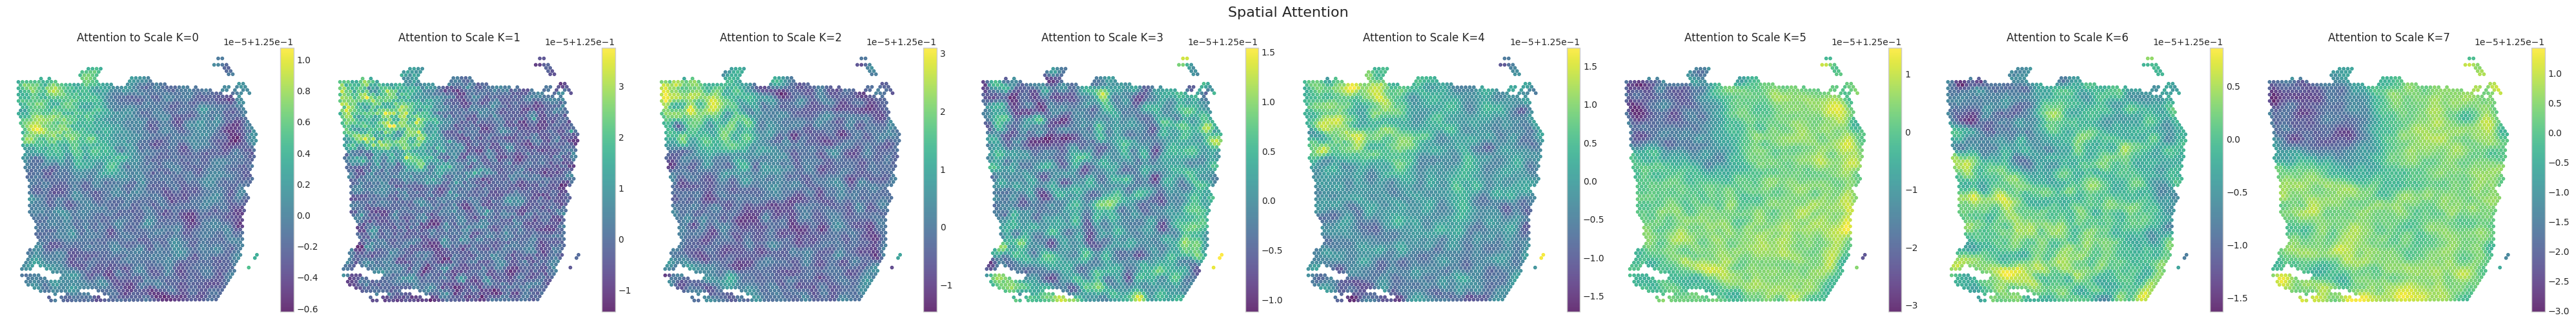

In [8]:
latent, attn = cps_model.infer_att_scores(pyg_data)
adata.obsm['z_t'] = latent
adata.obsm['attns'] = attn.reshape(adata.n_obs, 64)
attn = np.mean(attn, axis=2)

fitting ...
  |======================================================================| 100%


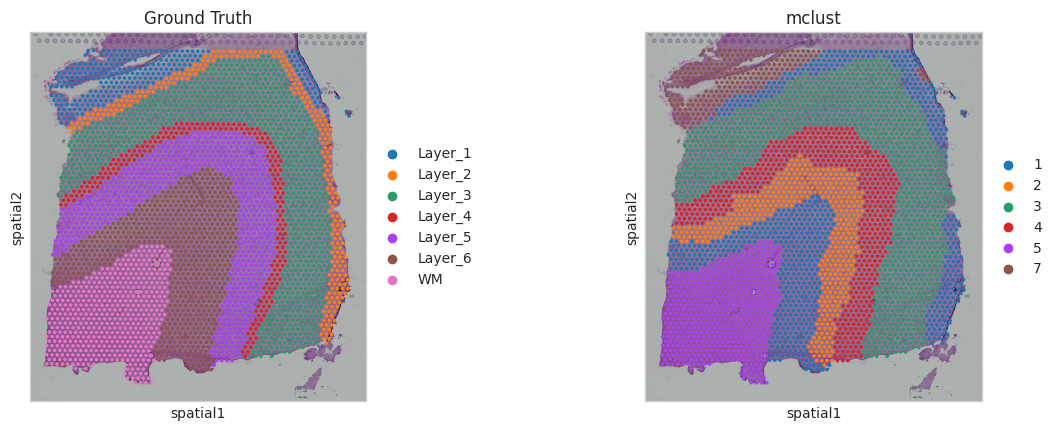

Adjusted rand index = 0.6085


In [15]:
# adata.obsm['z_t'] = latent
adata = CPS.mclust(adata, args, key='z_t', pca_dim=64, refine=True)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth", "mclust"])
adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

In [16]:
adata = CPS.mclust(adata, args, key='attns', pca_dim=32, refine=True)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth", "mclust"])
adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata.obs.dropna()
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

KeyError: 'attns'

In [13]:
import scanpy as sc
import pandas as pd
import numpy as np

# 1. 提取数据
# 假设 adata.obsm['attn'] 的形状是 (n_cells, n_scales)
attn_data = attn
n_scales = attn_data.shape[1]

# 2. 构建临时的 AnnData 对象
# 我们将 attention score 当作 "基因" 放入 X 中
adata_attn = sc.AnnData(X=attn_data)

# 3. 转移元数据 (Obs)
# 必须把 Ground Truth 标签复制过来，用于分组
adata_attn.obs['Ground Truth'] = adata.obs['Ground Truth'].values

# 4. 命名变量 (Var)
# 给每一个尺度起个名字，这将成为横轴的标签
scale_names = [f'Scale {i}' for i in range(n_scales)]
adata_attn.var_names = scale_names

# 5. 绘制热点图 (Point plot)
# groupby: 纵轴的分组依据 (20个空间域)
# var_names: 横轴的变量 (不同尺度)
sc.pl.dotplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth',
    standard_scale='var',  # 依然建议归一化，以便看清小尺度的变化
    cmap='Reds',
    figsize=(8, 10),
    title='Attention Intensity and Fraction'
)

ValueError: Length of values (3611) does not match length of index (3639)

In [12]:
# attn = np.mean(attn, axis=2)
attn = np.clip(attn, 1e-10, 1.0)
attn = attn / attn.sum(axis=1, keepdims=True)
weights = np.arange(1, 9)  # 尺度权重
SES = attn @ weights
SE = -np.sum(attn * np.log(attn), axis=1)
adata.obs['SES'] = SES
adata.obs['SE'] = SE

ValueError: Length of values (3639) does not match length of index (3611)

[<Axes: title={'center': 'SES'}, xlabel='spatial1', ylabel='spatial2'>]

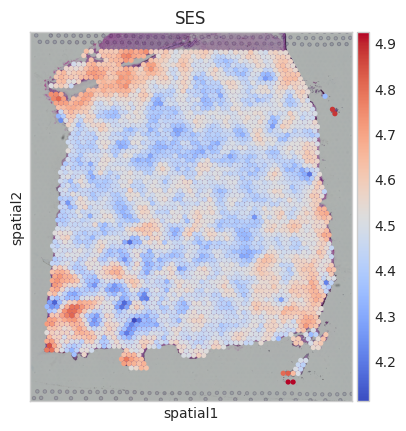

In [ ]:
temp_adata = adata.copy()
temp_adata.obs['SES'] = SES
sc.pl.spatial(temp_adata, 
                color='SES',
                show=False, cmap='coolwarm',
                size=1.5)

[<Axes: title={'center': 'SE'}, xlabel='spatial1', ylabel='spatial2'>]

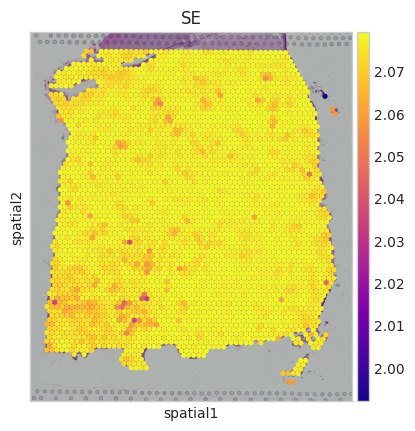

In [ ]:
temp_adata = adata.copy()
temp_adata.obs['SE'] = SE
sc.pl.spatial(temp_adata, 
                color='SE',
                show=False, 
                cmap='plasma',
                size=1.5)